In [1]:
!pip install librosa
!pip install tensorflow

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

from sklearn.preprocessing import LabelEncoder, StandardScaler, minmax_scale
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, log_loss

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from scipy.stats import loguniform, randint


with warnings.catch_warnings():
    warnings.simplefilter("ignore")

sns.set(style="whitegrid")

%matplotlib inline

In [3]:
!wget https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=0

--2024-12-11 08:47:03--  https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/logv7hsjc1t3daaysuhyh/genres.tar.gz?rlkey=vcu3jvliyletkjwxz8bv8jm7c&dl=0 [following]
--2024-12-11 08:47:03--  https://www.dropbox.com/scl/fi/logv7hsjc1t3daaysuhyh/genres.tar.gz?rlkey=vcu3jvliyletkjwxz8bv8jm7c&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucad3357be0dc3306b6314f0995a.dl.dropboxusercontent.com/cd/0/inline/CgDzKlRTAe_1E_STLxL369vlsR0Zk6IwSlCrHssMa_8Z8OSfyB9RCD_G0MO9c1fGJIqvPBQe7TdYf5P7mnDR8-rG2dYdkHTv9VrsVQCKgFs0HOGNTgl7X2P6zq0voJO9hnk/file# [following]
--2024-12-11 08:47:04--  https://ucad3357be0dc3306b6314f0995a.dl.dropboxusercontent.com/cd/0/inline/CgDz

In [4]:
!tar -xzvf /content/genres.tar.gz?dl=0

genres/
genres/blues/
genres/blues/blues.00000.au
genres/blues/blues.00001.au
genres/blues/blues.00002.au
genres/blues/blues.00003.au
genres/blues/blues.00004.au
genres/blues/blues.00005.au
genres/blues/blues.00006.au
genres/blues/blues.00007.au
genres/blues/blues.00008.au
genres/blues/blues.00009.au
genres/blues/blues.00010.au
genres/blues/blues.00011.au
genres/blues/blues.00012.au
genres/blues/blues.00013.au
genres/blues/blues.00014.au
genres/blues/blues.00015.au
genres/blues/blues.00016.au
genres/blues/blues.00017.au
genres/blues/blues.00018.au
genres/blues/blues.00019.au
genres/blues/blues.00020.au
genres/blues/blues.00021.au
genres/blues/blues.00022.au
genres/blues/blues.00023.au
genres/blues/blues.00024.au
genres/blues/blues.00025.au
genres/blues/blues.00026.au
genres/blues/blues.00027.au
genres/blues/blues.00028.au
genres/blues/blues.00029.au
genres/blues/blues.00030.au
genres/blues/blues.00031.au
genres/blues/blues.00032.au
genres/blues/blues.00033.au
genres/blues/blues.00034.a

In [5]:
audio_path = '/content/genres/blues/blues.00000.au'
audio, sr = librosa.load(audio_path)

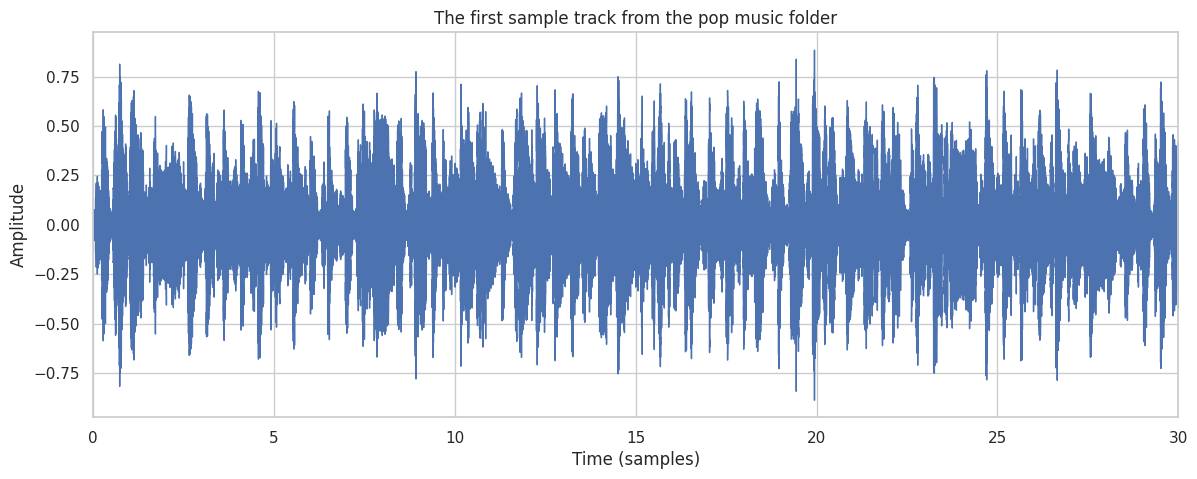

In [6]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('The first sample track from the pop music folder')
plt.xlim([0,30])
plt.show()

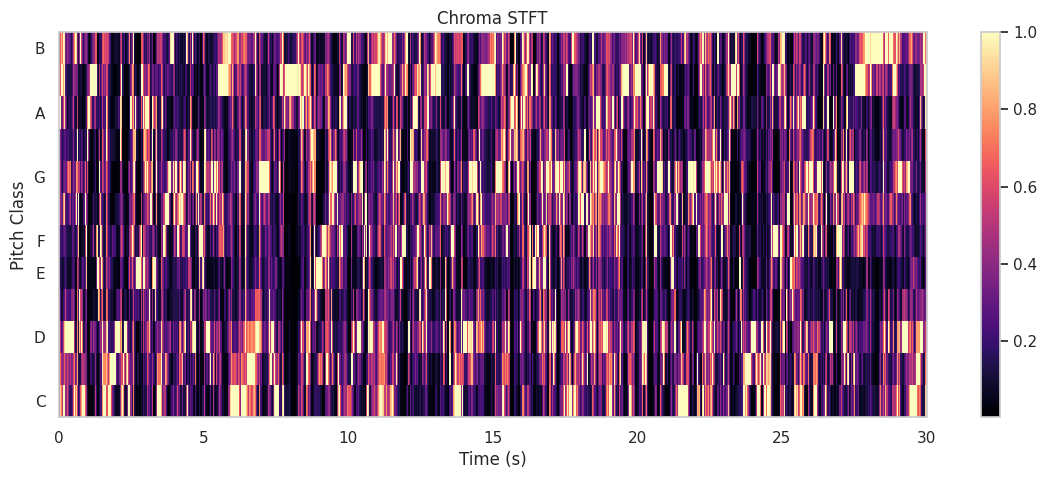

In [7]:
chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(chroma_stft, x_axis='time', y_axis='chroma', sr=sr)
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('Pitch Class')
plt.title('Chroma STFT')
plt.show()

In [8]:
rms = librosa.feature.rms(y=audio)
rms_mean = rms.mean()

print("RMS Mean:", rms_mean)

RMS Mean: 0.13018432


In [9]:
spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)
spectral_centroids_mean = spectral_centroids.mean()

print("Spectral Centroid Mean:", spectral_centroids_mean)

Spectral Centroid Mean: 1784.1226412753101


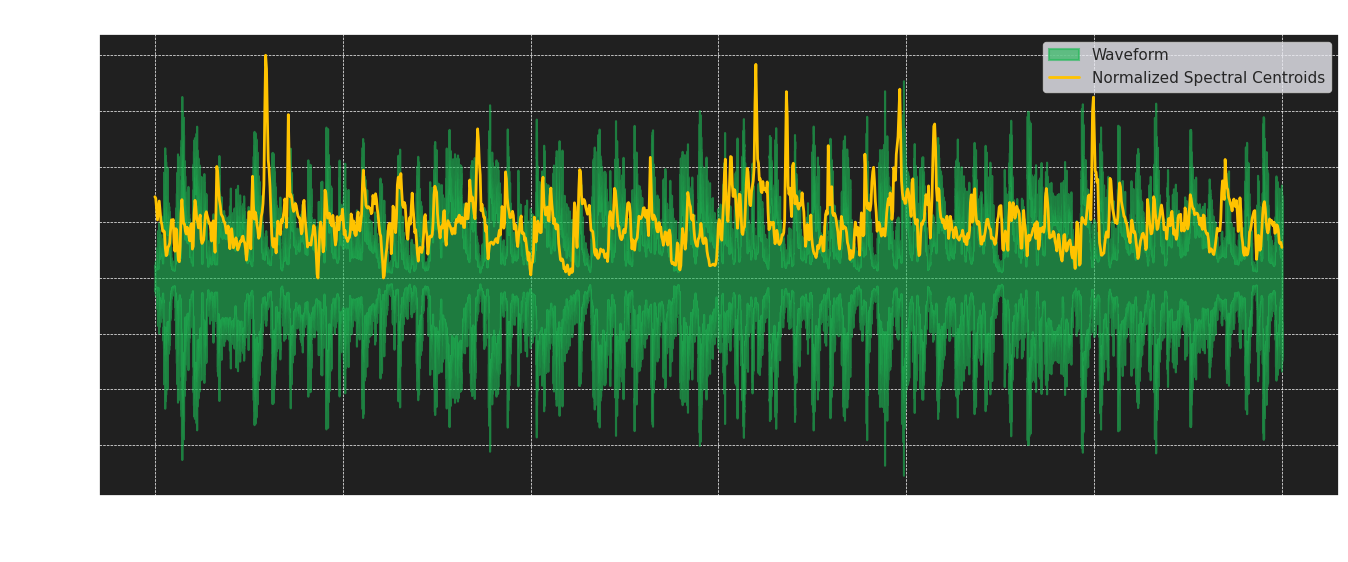

In [10]:
# Calculate the spectral centroids
spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)

# Computing the time variable for visualization
frames = range(len(spectral_centroids[0]))
t = librosa.frames_to_time(frames, sr=sr)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

# Use a stylish plot theme
sns.set_theme(style="darkgrid")

# Plotting the Spectral Centroid along the waveform
plt.figure(figsize=(16, 6))
ax = plt.axes()
ax.set_facecolor('#202020')  # Set a dark background color

# Waveform plot
librosa.display.waveshow(audio, sr=sr, alpha=0.6, color='#1DB954', linewidth=1.5, label='Waveform')

# Spectral centroids plot
plt.plot(t, normalize(spectral_centroids[0]), color='#FFC300', linewidth=2, label='Normalized Spectral Centroids')

# Enhancing the plot
plt.title('Waveform and Normalized Spectral Centroids', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Time (seconds)', fontsize=14, color='white')
plt.ylabel('Normalized Amplitude / Frequency', fontsize=14, color='white')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')

# Show the plot
plt.show()

In [11]:
spectral_bandwidths = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
spectral_bandwidths_mean = spectral_bandwidths.mean()

print("Spectral Bandwidth Mean:", spectral_bandwidths_mean)

Spectral Bandwidth Mean: 2002.4124072733878


In [12]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
spectral_rolloff_mean = spectral_rolloff.mean()

print("Spectral Rolloff Mean:", spectral_rolloff_mean)

Spectral Rolloff Mean: 3805.7230301080335


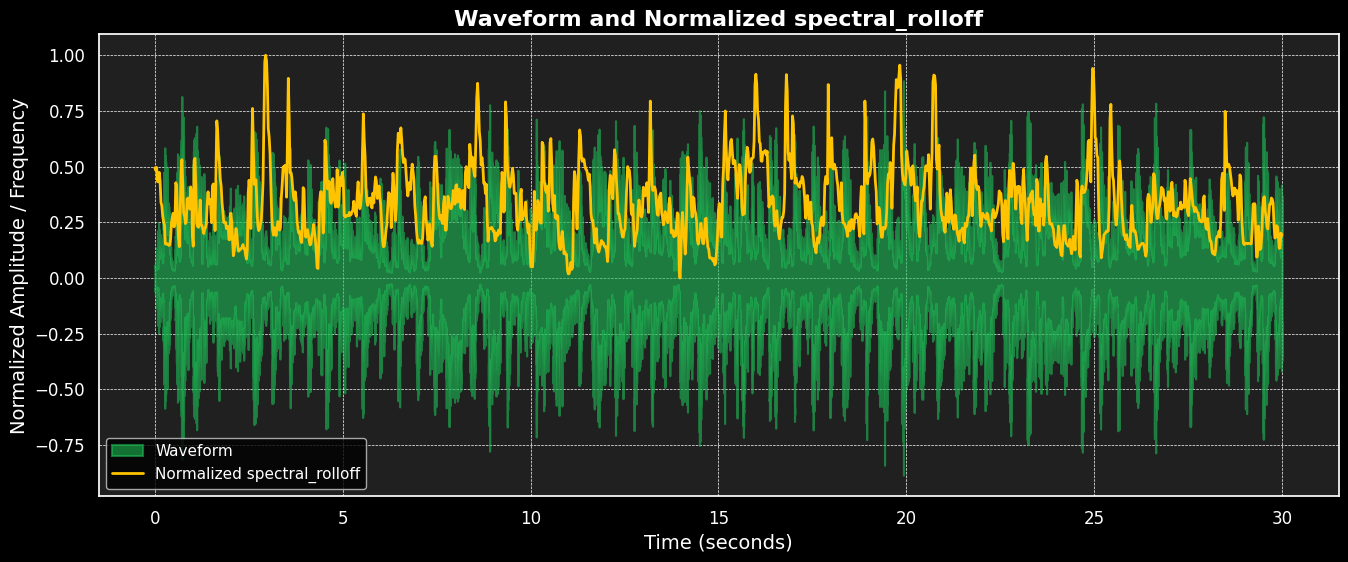

In [13]:
# Computing the time variable for visualization
frames = range(len(spectral_rolloff [0]))
t = librosa.frames_to_time(frames, sr=sr)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

# Use a stylish plot theme
plt.style.use(style = 'dark_background')

# Plotting the spectral_rolloff along the waveform
plt.figure(figsize=(16, 6))
ax = plt.axes()
ax.set_facecolor('#202020')  # Set a dark background color

# Waveform plot
librosa.display.waveshow(audio, sr=sr, alpha=0.6, color='#1DB954', linewidth=1.5, label='Waveform')

# chroma_cens plot
plt.plot(t, normalize(spectral_rolloff[0]), color='#FFC300', linewidth=2, label='Normalized spectral_rolloff')

# Enhancing the plot
plt.title('Waveform and Normalized spectral_rolloff', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Time (seconds)', fontsize=14, color='white')
plt.ylabel('Normalized Amplitude / Frequency', fontsize=14, color='white')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')

# Show the plot
plt.show()

In [14]:
zero_crossing_rates = librosa.feature.zero_crossing_rate(y=audio)
zero_crossing_rates_mean = zero_crossing_rates.mean()

print("Zero-Crossing Rate Mean:", zero_crossing_rates_mean)

Zero-Crossing Rate Mean: 0.08304482066898686


In [15]:
chroma_cens = librosa.feature.chroma_cens(y=audio, sr=sr)
harmony_mean = chroma_cens.mean()

print("Harmony Mean:", harmony_mean)

Harmony Mean: 0.27226317


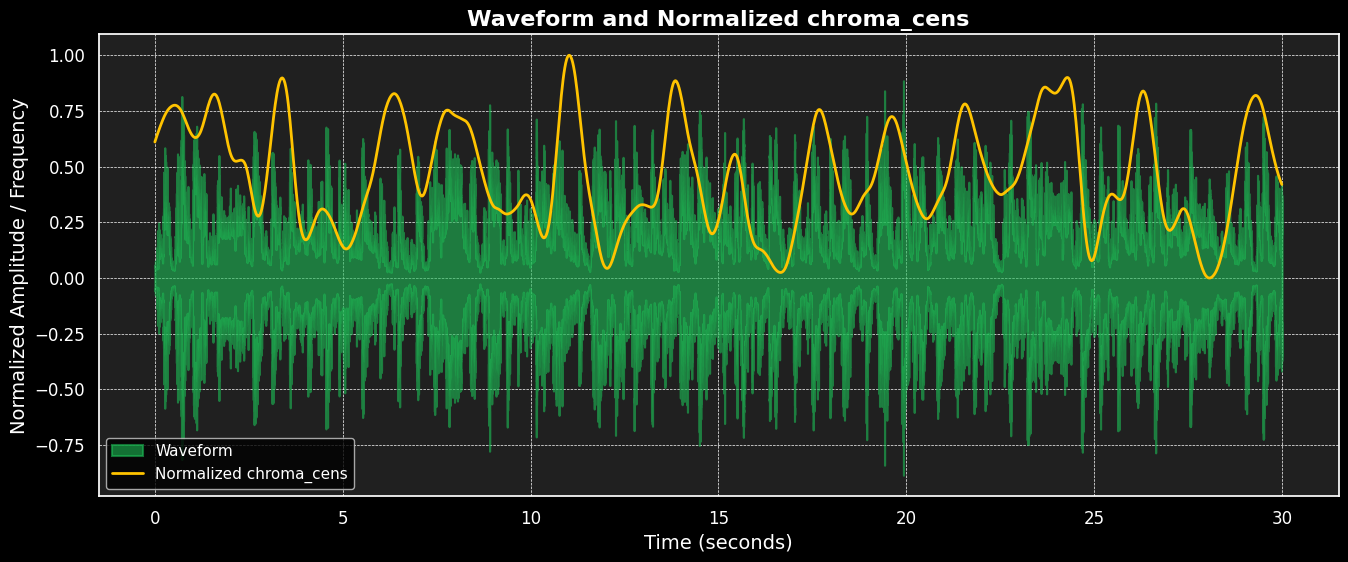

In [16]:
# Computing the time variable for visualization
frames = range(len(chroma_cens[0]))
t = librosa.frames_to_time(frames, sr=sr)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

# Use a stylish plot theme
plt.style.use(style = 'dark_background')

# Plotting the Spectral Centroid along the waveform
plt.figure(figsize=(16, 6))
ax = plt.axes()
ax.set_facecolor('#202020')  # Set a dark background color

# Waveform plot
librosa.display.waveshow(audio, sr=sr, alpha=0.6, color='#1DB954', linewidth=1.5, label='Waveform')

# chroma_cens plot
plt.plot(t, normalize(chroma_cens[0]), color='#FFC300', linewidth=2, label='Normalized chroma_cens')

# Enhancing the plot
plt.title('Waveform and Normalized chroma_cens', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Time (seconds)', fontsize=14, color='white')
plt.ylabel('Normalized Amplitude / Frequency', fontsize=14, color='white')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')

# Show the plot
plt.show()

In [17]:
tempo, _ = librosa.beat.beat_track(y=audio, sr=sr)
tempo_mean = tempo.mean()

print("Tempo Mean (BPM):", tempo_mean)

Tempo Mean (BPM): 123.046875


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:280: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


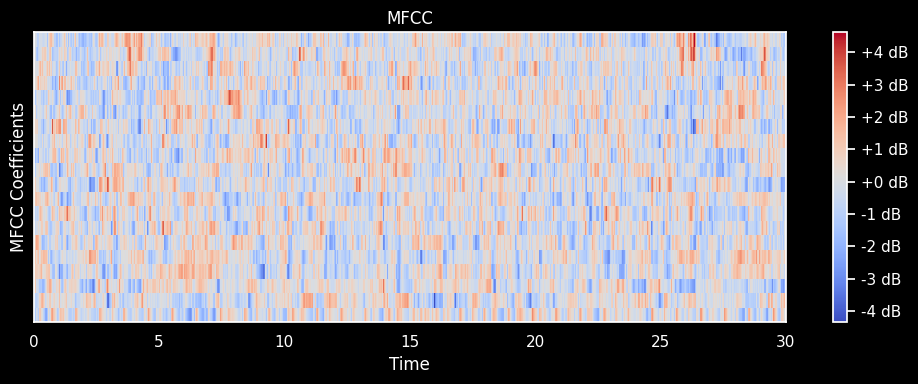

In [18]:
import sklearn
# Compute MFCCs
mfccs = librosa.feature.mfcc(y=audio, sr=sr)

# Apply Feature Scaling
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)

# Plot MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.tight_layout()
plt.show()

In [19]:
categories = ['blues', 'classical', 'country', 'disco', 'hiphop',
              'jazz', 'metal', 'pop', 'reggae', 'rock']

In [20]:
n_mfcc = 40
features = []
labels = []

In [21]:
import os

In [22]:
audio_dataset_path = '/content/genres' # Change this line to the correct path of your dataset.
for category in categories:
    category_path = os.path.join(audio_dataset_path, category)  # Now, category_path is correct
    label = categories.index(category)

    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)

        try:
            # Load audio file
            audio, sr = librosa.load(file_path, sr=None)

            # Extract features (e.g., MFCCs)
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
            mfccs_mean = np.mean(mfccs.T, axis=0)  # Take mean across time steps

            # Append features and labels
            features.append(mfccs_mean)
            labels.append(label)
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

In [23]:
# Convert to NumPy arrays
X = np.array(features)
y = np.array(labels)

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
# Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)

In [27]:
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [28]:
dt_preds = dt_model.predict_proba(X_test)
dt_loss = log_loss(y_test, dt_preds)
dt_accuracy = accuracy_score(y_test, dt_model.predict(X_test))

In [29]:
print(f"Decision Tree Loss: {dt_loss}")
print(f"Decision Tree Accuracy: {dt_accuracy}")

Decision Tree Loss: 21.809876036318673
Decision Tree Accuracy: 0.39


In [30]:
# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

In [31]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [32]:
rf_preds = rf_model.predict_proba(X_test)
rf_loss = log_loss(y_test, rf_preds)
rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test))

In [33]:
print(f"Random Forest Loss: {rf_loss}")
print(f"Random Forest Accuracy: {rf_accuracy}")

Random Forest Loss: 1.3384302907133365
Random Forest Accuracy: 0.605


In [34]:
# Support Vector Machine Classifier
svm_model = SVC(probability=True, random_state=42)

In [35]:
svm_model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [36]:
svm_preds = svm_model.predict_proba(X_test)
svm_loss = log_loss(y_test, svm_preds)
svm_accuracy = accuracy_score(y_test, svm_model.predict(X_test))

In [37]:
print(f"SVM Loss: {svm_loss}")
print(f"SVM Accuracy: {svm_accuracy}")

SVM Loss: 1.0777459334706796
SVM Accuracy: 0.61


In [38]:
# K-Nearest Neighbors Classifier
knn_model = KNeighborsClassifier()

In [39]:
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [40]:
knn_preds = knn_model.predict_proba(X_test)
knn_loss = log_loss(y_test, knn_preds)
knn_accuracy = accuracy_score(y_test, knn_model.predict(X_test))

In [41]:
print(f"KNN Loss: {knn_loss}")
print(f"KNN Accuracy: {knn_accuracy}")

KNN Loss: 7.7276386754800885
KNN Accuracy: 0.465


In [42]:
# Building a simple neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation='softmax')  # Adjust output layer for the number of genres
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [44]:
# Training the model
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    verbose=1)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.0821 - loss: 2.4968 - val_accuracy: 0.2375 - val_loss: 2.1693
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2438 - loss: 2.1238 - val_accuracy: 0.3000 - val_loss: 2.0046
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3154 - loss: 1.9016 - val_accuracy: 0.3313 - val_loss: 1.8905
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4016 - loss: 1.7532 - val_accuracy: 0.3625 - val_loss: 1.8023
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3988 - loss: 1.7140 - val_accuracy: 0.4125 - val_loss: 1.7197
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4635 - loss: 1.5763 - val_accuracy: 0.4125 - val_loss: 1.6446
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4530 - loss: 1.5481 - val_accuracy: 0.4187 - val_loss: 1.5871
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4917 - loss: 1.4423 - val_accuracy: 0.4250 - val_loss

In [45]:
# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6484 - loss: 1.0881  
Test Loss: 1.2071207761764526
Test Accuracy: 0.6150000095367432


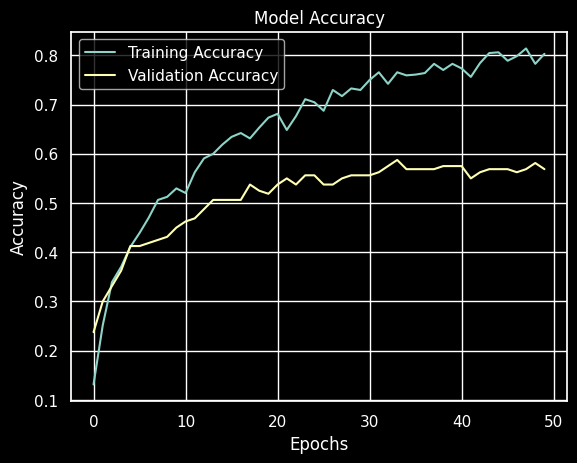

In [46]:
# Plotting training history

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()


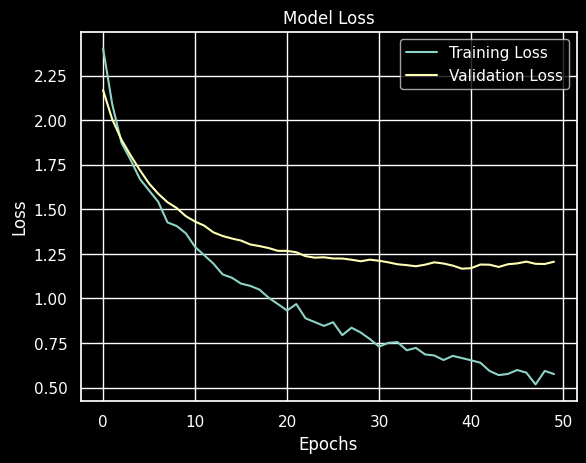

In [47]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()